#Preparing the Data

In [ ]:
import csv
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


tweets = []
target = []
with open("/content/drive/MyDrive/Colab Notebooks/Disaster Tweets/train.csv", 'r') as file:
  csvreader = csv.reader(file)
  first_row = False
  for row in csvreader:
    if not first_row:
      first_row = True
    else:
      tweets.append(row[3])
      target.append(row[-1])
tweets = np.array(tweets)
target = np.array(target,dtype="float32")


In [ ]:
print(tweets[:5])
print(target[:5])
print(len(target),len(tweets))

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']
[1. 1. 1. 1. 1.]
7613 7613


In [ ]:
tweets_len = [len(s) for s in tweets]

In [ ]:
print(max(tweets_len))

157


In [ ]:
np.percentile(tweets_len,97)

140.0

(array([  85.,  296.,  445.,  551.,  779.,  973.,  961., 1032., 2334.,
         157.]),
 array([  7.,  22.,  37.,  52.,  67.,  82.,  97., 112., 127., 142., 157.]),
 <a list of 10 Patch objects>)

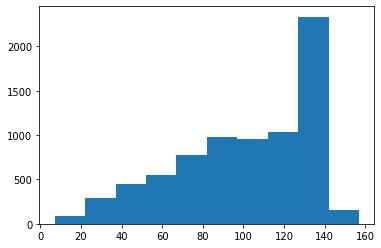

In [ ]:
plt.hist(tweets_len)

In [ ]:
tweets.shape

(7613,)

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(tweets,
                                                                target,
                                                                test_size=0.2, # dedicate 10% of samples to validation set
                                                                random_state=42) # random state for reproducibility

In [ ]:

OOV_TOKEN = "<OOV>"
MAXLEN = max([len(t) for t in train_sentences])
def preprocessing(tweets):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(
    oov_token=OOV_TOKEN
  )
  tokenizer.fit_on_texts(tweets)
  word_index = tokenizer.word_index
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = tf.keras.preprocessing.sequence.pad_sequences(sequences,padding="post",maxlen=MAXLEN)
  return tokenizer,padded,word_index

#Model_0 (baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.97%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.], dtype=float32)

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.97373604727511,
 'precision': 0.8102693639254774,
 'recall': 0.7997373604727511,
 'f1': 0.7932459520374361}

In [ ]:
#tweets_padded,word_index = preprocessing(train_sentences)
#tweets_padded_len = [len(p) for p in tweets_padded]
#tweets_padded[-1],tweets[-1]

In [ ]:
train_sentences.shape,train_labels.shape

((6090,), (6090,))

In [ ]:
val_sentences.shape,val_labels.shape

((1523,), (1523,))

In [ ]:
train_sentences

array(['Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR',
       '@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears',
       "Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN NOW &amp; RT! https://t.co/u4r8dRiuAc",
       ...,
       'Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x',
       'Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY',
       'I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7'],
      dtype='<U157')

In [ ]:
def preprocessing_test(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = tf.keras.preprocessing.sequence.pad_sequences(sequences,padding="post",maxlen=MAXLEN)
  return padded

In [ ]:
tokenizer,train_pad_seq,word_index = preprocessing(train_sentences)
train_pad_seq.shape

(6090, 157)

In [ ]:
# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[285,   3, 196,   4,  13, 720]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 19422
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['0106', '010217', '010156', '005225', '0011']


#Model_1 (Simple Dense Model)

In [ ]:
# Build model with the Functional API
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs) # inputs are 1-dimensional int
embedding = tf.keras.layers.Embedding(input_dim=len(word_index), # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform",
                             input_length=MAXLEN, # default, intialize randomly
                             name="embedding_1") 
x = embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         2490880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,491,009
Trainable params: 2,491,009
N

In [ ]:
val_pad_seq = preprocessing_test(tokenizer,val_sentences)
val_pad_seq.shape

(1523, 157)

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 [==============================] - 15s 68ms/step - loss: 0.6475 - accuracy: 0.6222 - val_loss: 0.5878 - val_accuracy: 0.7183
Epoch 2/5
191/191 [==============================] - 10s 51ms/step - loss: 0.4935 - accuracy: 0.8041 - val_loss: 0.4910 - val_accuracy: 0.7912
Epoch 3/5
191/191 [==============================] - 7s 39ms/step - loss: 0.3696 - accuracy: 0.8632 - val_loss: 0.4554 - val_accuracy: 0.8096
Epoch 4/5
191/191 [==============================] - 7s 34ms/step - loss: 0.2848 - accuracy: 0.9020 - val_loss: 0.4489 - val_accuracy: 0.8030
Epoch 5/5
191/191 [==============================] - 7s 34ms/step - loss: 0.2224 - accuracy: 0.9289 - val_loss: 0.4503 - val_accuracy: 0.8056


In [ ]:
model_1_preds = model_1.predict(val_sentences)
model_1_preds[:20]

array([[0.05352932],
       [0.24894384],
       [0.45641124],
       [0.05305812],
       [0.42758211],
       [0.1698392 ],
       [0.05016828],
       [0.40316534],
       [0.12900734],
       [0.67140007],
       [0.7621765 ],
       [0.25216866],
       [0.06532714],
       [0.41328993],
       [0.16551006],
       [0.2739948 ],
       [0.70879674],
       [0.0175871 ],
       [0.99442494],
       [0.05862561]], dtype=float32)

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=tf.round(model_1_preds))
model_1_results

{'accuracy': 80.56467498358502,
 'precision': 0.8062379617130846,
 'recall': 0.8056467498358503,
 'f1': 0.8033785285738717}

#Model_2 (RNN & Conv1D)

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs) # inputs are 1-dimensional int
embedding = tf.keras.layers.Embedding(input_dim=len(word_index), # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform",
                             input_length=MAXLEN, # default, intialize randomly
                             name="embedding_1") 
x = embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
# x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
# x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(4)(x) 
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_2 = tf.keras.Model(inputs, outputs, name="model_2_rnn_and_conv1D") # construct the model

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_rnn_and_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         2490880   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                          

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 [==============================] - 15s 55ms/step - loss: 0.5581 - accuracy: 0.7020 - val_loss: 0.4441 - val_accuracy: 0.8043
Epoch 2/5
191/191 [==============================] - 10s 51ms/step - loss: 0.3026 - accuracy: 0.8782 - val_loss: 0.4793 - val_accuracy: 0.7958
Epoch 3/5
191/191 [==============================] - 9s 49ms/step - loss: 0.1371 - accuracy: 0.9511 - val_loss: 0.5882 - val_accuracy: 0.7879
Epoch 4/5
191/191 [==============================] - 9s 49ms/step - loss: 0.0579 - accuracy: 0.9818 - val_loss: 0.8028 - val_accuracy: 0.7820
Epoch 5/5
191/191 [==============================] - 10s 50ms/step - loss: 0.0332 - accuracy: 0.9908 - val_loss: 0.8150 - val_accuracy: 0.7571


In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

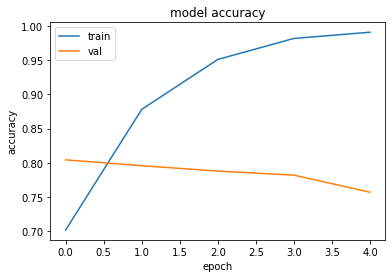

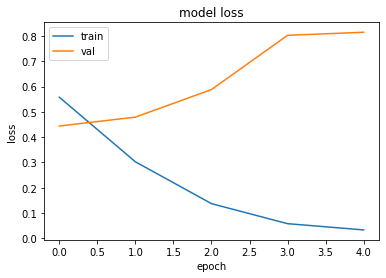

In [ ]:
plot_history(model_2_history)

In [ ]:
model_2_preds = model_2.predict(val_sentences)
model_2_preds[:20]

array([[2.1398067e-03],
       [7.9075050e-01],
       [1.8090039e-02],
       [4.3022037e-03],
       [2.0957083e-02],
       [1.9737831e-01],
       [5.7321012e-02],
       [1.8124998e-02],
       [7.0922464e-02],
       [9.8370719e-01],
       [7.6156867e-01],
       [6.3183695e-02],
       [8.6183637e-02],
       [7.7974617e-02],
       [9.6067488e-03],
       [1.1607063e-01],
       [9.8430526e-01],
       [5.7631254e-02],
       [9.9978065e-01],
       [1.5905499e-04]], dtype=float32)

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=tf.round(model_2_preds))
model_2_results

{'accuracy': 75.70584372948129,
 'precision': 0.7581951646466306,
 'recall': 0.7570584372948129,
 'f1': 0.7574957846747037}

#Model_3 (Using Transfer Learning)

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype="string")
x = sentence_encoder_layer(inputs)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
# # x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
# # x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
# x = tf.keras.layers.MaxPooling1D(4)(x) 
# # x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_3 = tf.keras.Model(inputs, outputs, name="model_3_USE_and_Dense") # construct the model

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE_and_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 [==============================] - 7s 19ms/step - loss: 0.5190 - accuracy: 0.7727 - val_loss: 0.4268 - val_accuracy: 0.8122
Epoch 2/5
191/191 [==============================] - 3s 15ms/step - loss: 0.4210 - accuracy: 0.8161 - val_loss: 0.4113 - val_accuracy: 0.8148
Epoch 3/5
191/191 [==============================] - 3s 15ms/step - loss: 0.4049 - accuracy: 0.8187 - val_loss: 0.4066 - val_accuracy: 0.8194
Epoch 4/5
191/191 [==============================] - 3s 15ms/step - loss: 0.3955 - accuracy: 0.8258 - val_loss: 0.4053 - val_accuracy: 0.8181
Epoch 5/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3885 - accuracy: 0.8287 - val_loss: 0.4072 - val_accuracy: 0.8214


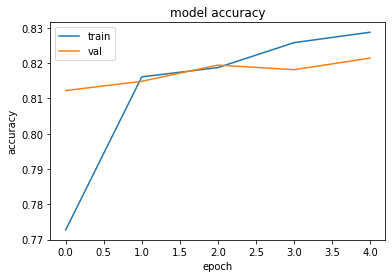

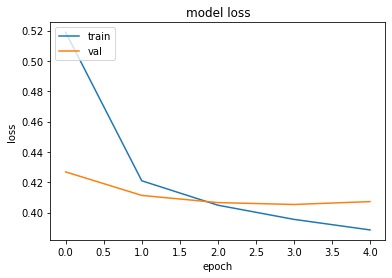

In [ ]:
plot_history(model_3_history)

In [ ]:
model_3_preds = model_3.predict(val_sentences)
model_3_preds[:20]

array([[0.09100258],
       [0.08131275],
       [0.41357467],
       [0.22969562],
       [0.21352535],
       [0.09483588],
       [0.1569621 ],
       [0.06930196],
       [0.35011476],
       [0.7511476 ],
       [0.6140736 ],
       [0.1248661 ],
       [0.09699488],
       [0.22660333],
       [0.11528388],
       [0.6869793 ],
       [0.67752194],
       [0.11668816],
       [0.9953755 ],
       [0.25032222]], dtype=float32)

In [ ]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=tf.round(model_3_preds))
model_3_results

{'accuracy': 82.14051214707814,
 'precision': 0.8208851515825114,
 'recall': 0.8214051214707814,
 'f1': 0.8205634808066425}

#Model_4 (USE & RNN & Conv1D)

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype="string")
x = sentence_encoder_layer(inputs)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Reshape(target_shape=(512, 1))(x)
x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
x = tf.keras.layers.Conv1D(64,5,activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(4)(x) 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_4 = tf.keras.Model(inputs, outputs, name="model_4_USE_and_RNN_and_Conv1D") # construct the model

# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_USE_and_RNN_and_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape (Reshape)           (None, 512, 1)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 508, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 504, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None,

In [ ]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 [==============================] - 105s 501ms/step - loss: 0.6844 - accuracy: 0.5678 - val_loss: 0.6855 - val_accuracy: 0.5739
Epoch 2/5
191/191 [==============================] - 90s 472ms/step - loss: 0.6833 - accuracy: 0.5732 - val_loss: 0.6745 - val_accuracy: 0.5739
Epoch 3/5
191/191 [==============================] - 89s 467ms/step - loss: 0.6296 - accuracy: 0.6507 - val_loss: 0.6015 - val_accuracy: 0.6730
Epoch 4/5
191/191 [==============================] - 90s 470ms/step - loss: 0.5814 - accuracy: 0.7018 - val_loss: 0.5863 - val_accuracy: 0.6907
Epoch 5/5
191/191 [==============================] - 90s 470ms/step - loss: 0.5634 - accuracy: 0.7158 - val_loss: 0.5547 - val_accuracy: 0.7170


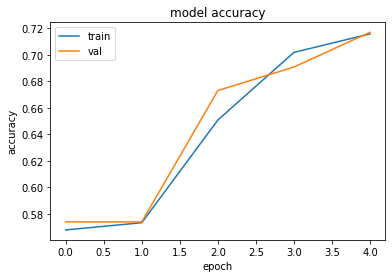

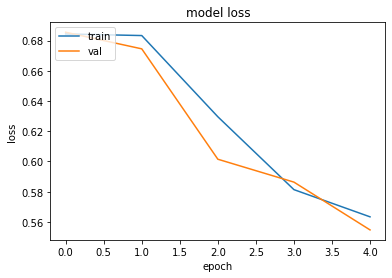

In [ ]:
plot_history(model_4_history)

In [ ]:
model_4_preds = model_4.predict(val_sentences)
model_4_preds[:20], model_4_preds.shape,val_labels.shape

(array([[0.28615898],
        [0.16111392],
        [0.48069912],
        [0.20662701],
        [0.38212797],
        [0.17178881],
        [0.1476363 ],
        [0.45086303],
        [0.26946548],
        [0.31961045],
        [0.7448033 ],
        [0.33560324],
        [0.22453669],
        [0.84863865],
        [0.2309289 ],
        [0.56794703],
        [0.6307022 ],
        [0.39003205],
        [0.8544673 ],
        [0.15986803]], dtype=float32), (1523, 1), (1523,))

In [ ]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=tf.round(model_4_preds))
model_4_results

{'accuracy': 71.70059093893632,
 'precision': 0.7148703049340791,
 'recall': 0.7170059093893631,
 'f1': 0.7143411980819451}

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  model_1.name: model_1_results,
                                  model_2.name: model_2_results,
                                  model_3.name: model_3_results,
                                  model_4.name: model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.973736,0.810269,0.799737,0.793246
model_1_dense,80.564675,0.806238,0.805647,0.803379
model_2_rnn_and_conv1D,75.705844,0.758195,0.757058,0.757496
model_3_USE_and_Dense,82.140512,0.820885,0.821405,0.820563
model_4_USE_and_RNN_and_Conv1D,71.700591,0.714870,0.717006,0.714341


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

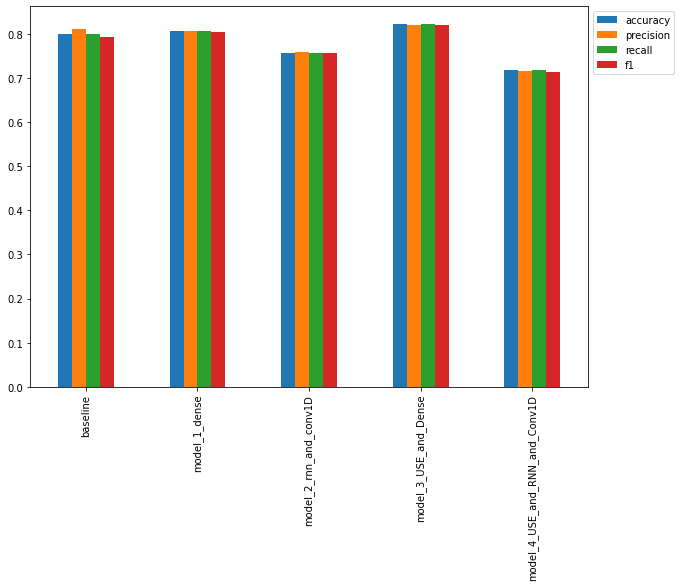

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

#Predicting using Model_3 on test dataset

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Disaster Tweets/test.csv", 'r') as file:
  csvreader = csv.reader(file)
  first_row = False
  for row in csvreader:
    print(row)


['id', 'keyword', 'location', 'text']
['0', '', '', 'Just happened a terrible car crash']
['2', '', '', 'Heard about #earthquake is different cities, stay safe everyone.']
['3', '', '', 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all']
['9', '', '', 'Apocalypse lighting. #Spokane #wildfires']
['11', '', '', 'Typhoon Soudelor kills 28 in China and Taiwan']
['12', '', '', "We're shaking...It's an earthquake"]
['21', '', '', "They'd probably still show more life than Arsenal did yesterday, eh? EH?"]
['22', '', '', 'Hey! How are you?']
['27', '', '', 'What a nice hat?']
['29', '', '', 'Fuck off!']
['30', '', '', "No I don't like cold!"]
['35', '', '', "NOOOOOOOOO! Don't do that!"]
['42', '', '', "No don't tell me that!"]
['43', '', '', 'What if?!']
['45', '', '', 'Awesome!']
['46', 'ablaze', 'London', "Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU"]
['47', 'ablaze', 

In [ ]:
test_tweets = []
with open("/content/drive/MyDrive/Colab Notebooks/Disaster Tweets/test.csv", 'r') as file:
  csvreader = csv.reader(file)
  first_row = False
  for row in csvreader:
    if not first_row:
      first_row = True
    else:
      test_tweets.append(row[3])
test_tweets = np.array(test_tweets)
test_tweets[:5],test_tweets.shape

(array(['Just happened a terrible car crash',
        'Heard about #earthquake is different cities, stay safe everyone.',
        'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
        'Apocalypse lighting. #Spokane #wildfires',
        'Typhoon Soudelor kills 28 in China and Taiwan'], dtype='<U151'),
 (3263,))

Training model_3 on the entire train.csv data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((tweets,target))
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(buffer_size=AUTOTUNE)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype="string")
x = sentence_encoder_layer(inputs)
x = tf.keras.layers.Dense(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_3_2 = tf.keras.Model(inputs, outputs, name="model_3_USE_and_Dense_2") # construct the model

# Compile model
model_3_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_2.summary()

Model: "model_3_USE_and_Dense_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_3_2.fit(train_ds,
            epochs=10)

Epoch 1/10
238/238 [==============================] - 8s 22ms/step - loss: 0.4886 - accuracy: 0.7812
Epoch 2/10
238/238 [==============================] - 6s 23ms/step - loss: 0.4112 - accuracy: 0.8152
Epoch 3/10
238/238 [==============================] - 5s 22ms/step - loss: 0.3977 - accuracy: 0.8233
Epoch 4/10
238/238 [==============================] - 3s 12ms/step - loss: 0.3874 - accuracy: 0.8313
Epoch 5/10
238/238 [==============================] - 3s 12ms/step - loss: 0.3772 - accuracy: 0.8349
Epoch 6/10
238/238 [==============================] - 3s 11ms/step - loss: 0.3675 - accuracy: 0.8391
Epoch 7/10
238/238 [==============================] - 3s 12ms/step - loss: 0.3562 - accuracy: 0.8441
Epoch 8/10
238/238 [==============================] - 3s 12ms/step - loss: 0.3451 - accuracy: 0.8495
Epoch 9/10
238/238 [==============================] - 3s 12ms/step - loss: 0.3325 - accuracy: 0.8559
Epoch 10/10
238/238 [==============================] - 3s 12ms/step - loss: 0.3214 - accura

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(test_tweets)
test_ds = test_ds.cache().batch(32).prefetch(buffer_size=AUTOTUNE)
test_ds

<PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [ ]:
test_preds = model_3_2.predict(test_ds)

In [ ]:
test_preds[:5],test_preds.shape

(array([[0.60258585],
        [0.97119725],
        [0.89157856],
        [0.97880054],
        [0.9908413 ]], dtype=float32), (3263, 1))

In [ ]:
test_preds = tf.round(test_preds)
test_preds[:20]

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)>

In [ ]:
id = []
with open("/content/drive/MyDrive/Colab Notebooks/Disaster Tweets/test.csv", 'r') as file:
  csvreader = csv.reader(file)
  first_row = False
  for row in csvreader:
    if not first_row:
      first_row = True
    else:
      id.append(row[0])
id = np.array(id)
id.shape,id[:5]

((3263,), array(['0', '2', '3', '9', '11'], dtype='<U5'))

In [ ]:
test_preds = tf.cast(test_preds,dtype="int32")
# creating the dataframe
df = pd.DataFrame()
df["id"] = id
df["target"] = test_preds
df.head()


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
df.to_csv(path_or_buf="/content/drive/MyDrive/Colab Notebooks/Disaster Tweets/submission.csv",index=False)